<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_experiment_refined_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T152011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db4ec61946419ca8b830a0f4613cac81dffb050d7d712972d73e73a8d24cc40a231fb1a47a2c7bce99a68ff93e9ac40d5a337ede5b14e8940c63ba216337c90b4cc432075b2f24e158971a25f9ecb52e84512e1cdc8473afcdfc20275099542b8cc23208d379bed1a7e644e96a929b7dbb91a7019f5331c94ea9f46d05bdd60badb9169961ed1faa90ae1290e3919c42a5736aa4fd68b941df0dac0e6957e4528a6663da154303292f0925fe7bc92d10ad202845647f7a1eff66f586604bb52c0626b2d95f3daf452d5dae6be3e0f2daf1e3177513be89acda9a7114a083009f77cf36a5edd56f41bb1bf1ba424974542d3b8bd7ac3ec5ab7122a096e033e4df9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [16]:
!pip install mtcnn

In [17]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


In [18]:
# Set the dataset path
dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Generate a list of (name, image count) tuples
names_images = []

for name in os.listdir(dataset_path):
    directory = os.path.join(dataset_path, name)
    if os.path.isdir(directory):
        images = [i for i in os.listdir(directory) if i.endswith('.jpg')]
        image_count = len(images)
        # Add to list if there are at least 25 images and store the actual image count
        if image_count >= 30:
            names_images.append((name, min(image_count, 30)))

# Update number_of_people to reflect the actual number of people with at least 25 images
number_of_people = len(names_images)
print(f"Number of people with at least 25 images: {number_of_people}")

# Create a DataFrame
lfw_allnames = pd.DataFrame(names_images, columns=['name', 'images'])

# Save the DataFrame to a CSV file
lfw_csv_path = '../input/lfw-dataset/lfw_allnames.csv'
lfw_allnames.to_csv(lfw_csv_path, index=False)

print(f"CSV file created at: {lfw_csv_path}")

Number of people with at least 25 images: 34
CSV file created at: ../input/lfw-dataset/lfw_allnames.csv


In [19]:
# Define a new directory for experiments
new_dir_path = '../lfw-data-experiment'

# Create the new directory if it doesn't exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

# Move the folders
for name, image_count in names_images:
    source_folder = os.path.join(dataset_path, name)
    destination_folder = os.path.join(new_dir_path, name)

    # Check if the destination folder already exists
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)

    # Move the folders
    if os.path.exists(source_folder):
        shutil.copytree(source_folder, destination_folder)
        # If there are more than 25 images, keep the first 25 and delete the rest
        images = sorted([i for i in os.listdir(destination_folder) if i.endswith('.jpg')])
        for img in images[30:]:  # Delete all images beyond the 25th
            os.remove(os.path.join(destination_folder, img))
    else:
        print(f"Folder for {name} does not exist in the dataset path.")

print("Folders moved successfully.")

Folders moved successfully.


In [20]:

# Read the dataset
people_data = os.listdir(new_dir_path)
people = []
for item in people_data:
    person_images = os.listdir(os.path.join(new_dir_path, item))
    for person_image in person_images:
        people.append((item, os.path.join(new_dir_path, item, person_image)))

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Convert labels to one-hot encoded labels
label_encoder = LabelEncoder()
labels = people_df['person'].values
int_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(int_encoded)

# Correct the size of the images to match the CNN input
im_size = 200

# Initialize lists to store the images and labels
images = []
labels = []

# Load and preprocess the images
for index, row in people_df.iterrows():
    img = cv2.imread(row['path'])
    img = cv2.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(row['person'])

images = np.array(images)
images = images.astype('float32') / 255.0

# Shuffle and split the dataset
images, y_onehot = shuffle(images, y_onehot, random_state=1)
train_x, test_x, train_y_onehot, test_y_onehot = train_test_split(images, y_onehot, test_size=0.3, random_state=415)

# Check the shapes again to make sure they match
print("train_x shape:", train_x.shape)
print("train_y_onehot shape:", train_y_onehot.shape)
print("test_x shape:", test_x.shape)
print("test_y_onehot shape:", test_y_onehot.shape)

train_x shape: (714, 200, 200, 3)
train_y_onehot shape: (714, 34)
test_x shape: (306, 200, 200, 3)
test_y_onehot shape: (306, 34)


In [21]:
import os

# Correct path according to your folder structure
lfw_data_experiment = '../lfw-data-experiment'

people_data = os.listdir(lfw_data_experiment)
print(len(people_data))

people = []
for item in people_data:
    all_names = os.listdir(lfw_data_experiment + '/' + item)
    for person in all_names:
        people.append((item, lfw_data_experiment + '/' + item + '/' + person))

print(people)


34
[('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0015.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0029.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0016.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0007.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0012.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0008.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0030.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0004.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0020.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0006.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0026.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0022.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo

In [22]:
import pandas as pd

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Count the number of samples for each person
person_count = people_df['person'].value_counts()

print("Total number of images of people in the dataset: ", len(people_df))
print("Samples in each category: ")
print(person_count)


Total number of images of people in the dataset:  1020
Samples in each category: 
person
Roh_Moo-hyun                 30
David_Beckham                30
Silvio_Berlusconi            30
Andre_Agassi                 30
Kofi_Annan                   30
Ariel_Sharon                 30
Megawati_Sukarnoputri        30
Donald_Rumsfeld              30
Tom_Ridge                    30
Junichiro_Koizumi            30
John_Negroponte              30
John_Ashcroft                30
Luiz_Inacio_Lula_da_Silva    30
Guillermo_Coria              30
Gerhard_Schroeder            30
Hans_Blix                    30
Jean_Chretien                30
Laura_Bush                   30
Colin_Powell                 30
Arnold_Schwarzenegger        30
Gloria_Macapagal_Arroyo      30
Jacques_Chirac               30
Vladimir_Putin               30
Jennifer_Capriati            30
Serena_Williams              30
Nestor_Kirchner              30
Alejandro_Toledo             30
Recep_Tayyip_Erdogan         30
Vicente_Fox    

#Encoding

In [23]:
num_classes = len(np.unique(labels))

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(im_size, im_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the results to feed into a dense layer
    Flatten(),

    # 256 neurons in the fully connected layer
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout for regularization

    # Output layer with one neuron per class
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 198, 198, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                      

In [25]:
print("train_x shape:", train_x.shape)  # Should be (735, height, width, channels)
print("train_y_onehot shape:", train_y_onehot.shape)  # Should be (735, num_classes)
print("test_x shape:", test_x.shape)  # Adjusted to the correct number of test samples
print("test_y_onehot shape:", test_y_onehot.shape)  # Adjusted to the correct number of test samples


train_x shape: (714, 200, 200, 3)
train_y_onehot shape: (714, 34)
test_x shape: (306, 200, 200, 3)
test_y_onehot shape: (306, 34)


In [26]:
history = model.fit(
    train_x,
    train_y_onehot,
    epochs=10,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)


Epoch 1/10
23/23 [==============================] - 6s 162ms/step - loss: 5.7081 - accuracy: 0.0490 - val_loss: 3.5244 - val_accuracy: 0.0490
Epoch 2/10
23/23 [==============================] - 2s 71ms/step - loss: 3.4555 - accuracy: 0.0840 - val_loss: 3.4982 - val_accuracy: 0.0621
Epoch 3/10
23/23 [==============================] - 2s 75ms/step - loss: 3.2059 - accuracy: 0.1303 - val_loss: 3.4245 - val_accuracy: 0.1176
Epoch 4/10
23/23 [==============================] - 2s 77ms/step - loss: 2.9657 - accuracy: 0.1919 - val_loss: 3.3673 - val_accuracy: 0.1503
Epoch 5/10
23/23 [==============================] - 2s 77ms/step - loss: 2.7027 - accuracy: 0.2339 - val_loss: 3.2658 - val_accuracy: 0.1928
Epoch 6/10
23/23 [==============================] - 2s 91ms/step - loss: 2.3465 - accuracy: 0.3151 - val_loss: 3.1764 - val_accuracy: 0.2320
Epoch 7/10
23/23 [==============================] - 2s 81ms/step - loss: 1.9484 - accuracy: 0.4258 - val_loss: 3.0348 - val_accuracy: 0.2778
Epoch 8/10
2

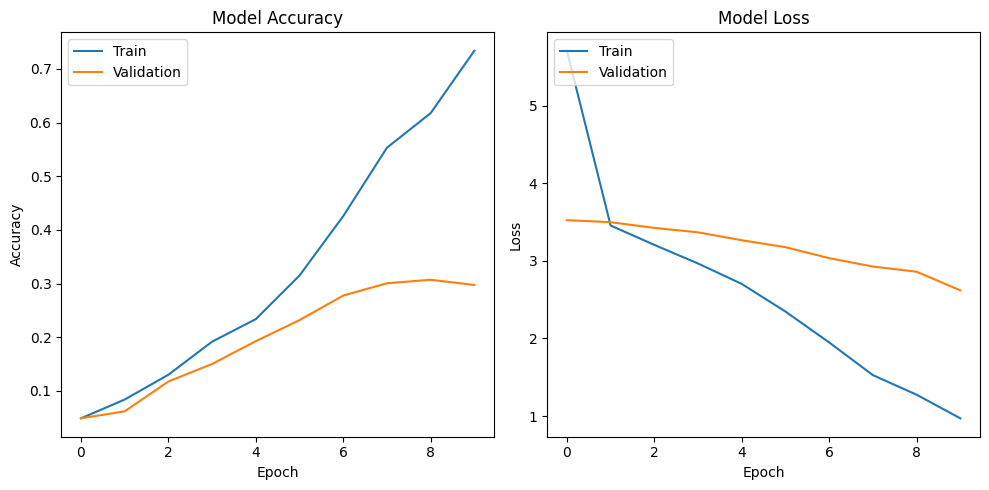

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this line is active
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # And this line is active
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Your pre-built and compiled model, assumed to be trained already.
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

# If you one-hot encoded the test labels for training,
# you need to reverse the one-hot encoding to get the original class indices.
actual_classes = np.argmax(test_y_onehot, axis=1)

# Inverse transform the predicted and actual class indices to their original names.
predicted_class_names = label_encoder.inverse_transform(predicted_classes)
actual_class_names = label_encoder.inverse_transform(actual_classes)

# Generate the classification report.
report = classification_report(actual_class_names, predicted_class_names, target_names=label_encoder.classes_)

print(report)


10/10 [==============================] - 0s 20ms/step
                           precision    recall  f1-score   support

         Alejandro_Toledo       0.25      0.33      0.29         6
             Alvaro_Uribe       0.44      0.54      0.48        13
             Andre_Agassi       0.54      0.64      0.58        11
             Ariel_Sharon       0.11      0.25      0.15         8
    Arnold_Schwarzenegger       0.06      0.11      0.08         9
             Colin_Powell       0.33      0.12      0.18         8
            David_Beckham       0.00      0.00      0.00         6
          Donald_Rumsfeld       0.43      0.30      0.35        10
            George_W_Bush       0.00      0.00      0.00         7
        Gerhard_Schroeder       0.55      0.67      0.60         9
  Gloria_Macapagal_Arroyo       0.44      0.67      0.53         6
          Guillermo_Coria       0.70      0.54      0.61        13
                Hans_Blix       0.11      0.12      0.12         8
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
